In [11]:
import numpy as np
import pybamm
import matplotlib.pyplot as plt
from pandas import DataFrame
from utils.generate_new_volume import generate_new_volume
from utils.physical_properties import *
from utils.plotting import plot_volume
from skimage.transform import rescale, downscale_local_mean

# 4 phase volumes
phases = ['Pore','Crack','Particle','CBD']

# Volume generation
def generate_new_volume_rve(reduction, subregion_id, subregion):
    model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
    model_path = 'model/{}/{}'.format(model_name, model_name)

    # Need to modify output size so the size of the generated volume is the same regardless of training image resolution
    output_sz = 120 # lz default 8 at 20% reduction gives output size of 192 (120 is the biggest i can run locally)
    lz = int((((output_sz * reduction) / 0.2)+64)/32)
    vol = generate_new_volume(model_path=model_path, lz=lz)
    # downscale higher resolution images to avoid taking a really long time, rounding to preseve segmented
    vol_reduced = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)
    return vol, vol_reduced

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def properties_and_echem_from_volume(reduction, subregion_id, subregion, n=20, is_plot=True, is_save=True):
    capacities = np.zeros((n,1))
    vfs_particle = np.zeros((n,1))
    vfs_pore = np.zeros((n,1))
    D_effs = np.zeros((n,1))

    for i in range(n):
        vol = generate_new_volume_rve(reduction, subregion_id, subregion)
        '''
        Properties to modify:
        - Positive electrode porosity
        - Positive electrode active material volume fraction
        Things to work on later:
        - inputting Deff into positive electrode diffusivity (need to modify function in parameters)
        - inputting particle size (current volume is too small to have 'particles')
            - use surface area to reverse calculate particle size? particle size controls surface area in pybamm (sphere = 3/(r*(1-vf_pore)))
        '''
        # Set all cracks and pores equal for porosity
        vol[vol==1] = 0
        vf_particle = volume_fraction(vol, phase_class=2)
        vf_pore     = volume_fraction(vol, phase_class=0)
        # # pybamm can fail at extreme values
        # if vf_particle > 0.85:
        #     vf_particle = 0.85
        # if vf_pore < 0.09:
        #     vf_pore = 0.09

        # Diffusivity and tortuosity
        # Set all phases to 0 except particle for taufactor
        vol[vol==3] = 0
        vol[vol==2] = 1
        homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
        D_eff = homogenized_properties['D_eff'].item()

        vfs_particle[i] = vf_particle
        vfs_pore[i] = vf_pore
        D_effs[i] = D_eff

        # PyBaMM model
        model = pybamm.lithium_ion.DFN()
        # Default parameter set
        params = pybamm.ParameterValues("Marquis2019")
        # Modify parameters
        params['Positive electrode porosity'] = vf_pore
        params['Positive electrode active material volume fraction'] = vf_particle
        params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
        # Run the simulation
        sim = pybamm.Simulation(model,parameter_values=params)
        sim.solve([0, 7200],initial_soc=1)
        sol = sim.solution
        # Save the discharge capacity
        capacities[i] = sol['Discharge capacity [A.h]'].entries[-1]
        
        # Save the simulation
        dis_ah = sol['Discharge capacity [A.h]'].entries.squeeze()
        dis_vol = sol['Voltage [V]'].entries.squeeze()
        if i==0:
            discharge_amphours = [dis_ah]
            voltage = [dis_vol]
        else:
            discharge_amphours += [dis_ah]
            voltage += [dis_vol]

        # Plot to see if the simulations are any different
        if is_plot:
            plt.plot(sol['Discharge capacity [A.h]'].entries, sol['Voltage [V]'].entries)

    if is_plot:
        plt.xlabel('Discharge Amphours')
        plt.ylabel('Voltage')
        plt.show()
        
    if is_save:
        reduction_ = np.full_like(D_effs, reduction).squeeze()
        subregion_ = np.full_like(D_effs, subregion).squeeze()
        subregion_id_ = np.full_like(D_effs, subregion_id).squeeze()
        results = DataFrame({
            "reduction": reduction_,
            "subregion": subregion_,
            "subregion_id": subregion_id_,
            "vf particle": vfs_particle.squeeze(),
            "vf pore": vfs_pore.squeeze(),
            "D eff": D_effs.squeeze(),
            "discharge amphours": discharge_amphours,
            "voltage": voltage,
        })
        model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
        results.to_json('results/' + model_name + '.json')
    
    return vfs_particle, vfs_pore, D_effs, capacities, discharge_amphours, voltage

In [12]:
reduction = [1.0, 0.8, 0.6, 0.4, 0.2]
for red in reduction:
    vol, vol_reduced = generate_new_volume_rve(red, 1, 1)
    path = 'img/slicegan_r{}_s{}{}_slice.png'.format(str(red).replace('.', 'p'), str(1), str(1))
    
    fig, ax = plt.subplots(2, 3)
    ax = ax.ravel()
    ax[0].imshow(vol[10, :, :], cmap = 'gray')
    ax[1].imshow(vol[:, 10, :], cmap = 'gray')
    ax[2].imshow(vol[:, :, 10], cmap = 'gray')
    ax[3].imshow(vol_reduced[10, :, :], cmap = 'gray')
    ax[4].imshow(vol_reduced[:, 10, :], cmap = 'gray')
    ax[5].imshow(vol_reduced[:, :, 10], cmap = 'gray')

    plt.savefig(path)
    plt.close()

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59829875152 bytes.

/home/pgasper/.conda-envs/ustruct-to-echem/lib/python3.11/site-packages/taufactor/taufactor.py:39: UserWarning: CUDA not available, defaulting device to cpu. To avoid this warning, explicitly set the device when initialising the solver with device=torch.device('cpu')
  warnings.warn(
At t = 514.519 and h = 4.5376e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.61 and h = 2.64118e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 529.848 and h = 5.32099e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.939 and h = 5.62689e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.4842 and h = 5.86235e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.354 and h = 6.79503e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 209.445 and h = 7.62606e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 561.667 an

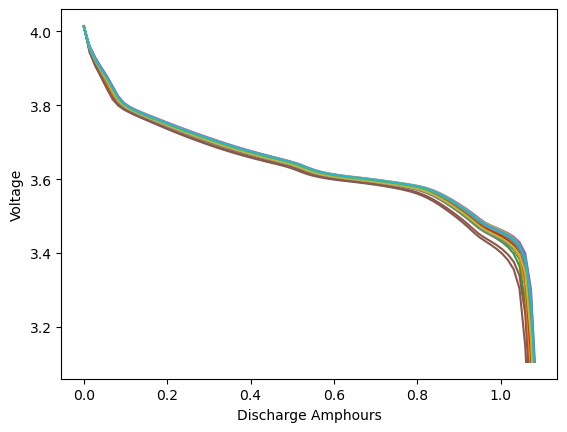

At t = 540.284 and h = 5.52101e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 249.375 and h = 7.12976e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.92, repeated recoverable residual errors.
At t = 522.682 and h = 2.58777e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.772 and h = 4.38587e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 562.144 and h = 1.28717e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.235 and h = 2.97572e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 125.781 and h = 3.80427e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 519.217 and h = 1.14294e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.307 and h = 5.74549e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 527.903 and h = 5.38159e-13, the correct

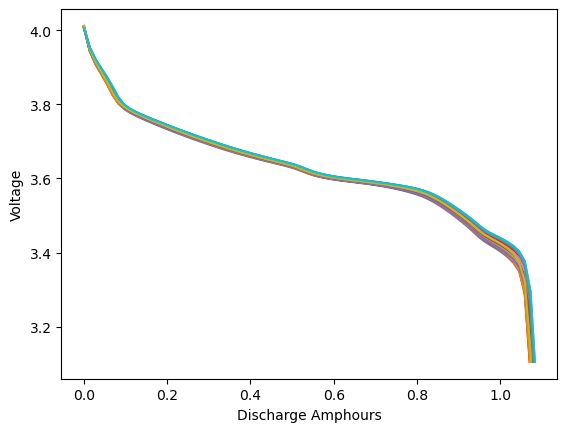

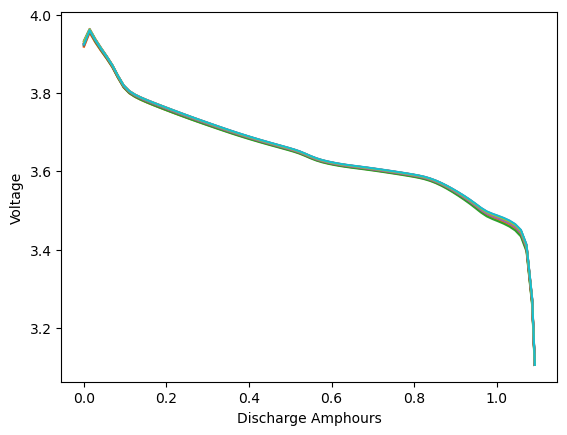

At t = 495.552 and h = 2.48166e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.643 and h = 1.38401e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 481.364 and h = 2.0327e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.455 and h = 6.70327e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 466.456 and h = 1.90533e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 175.547 and h = 3.47124e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 470.885 and h = 6.19713e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 179.976 and h = 2.15521e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 461.033 and h = 3.02635e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 170.124 and h = 2.52216e-15, the corrector convergence failed repeatedly or with |h| = hmin.
A

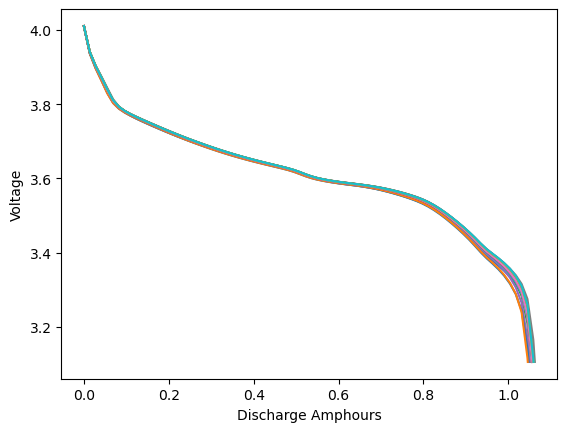

At t = 506.289 and h = 4.8183e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 215.38 and h = 4.8148e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 508.448 and h = 1.33043e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 217.539 and h = 5.23179e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 512.222 and h = 1.89825e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 221.312 and h = 4.64823e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 514.81 and h = 7.32256e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.901 and h = 1.52073e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 513.545 and h = 7.26235e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 222.636 and h = 6.31482e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t

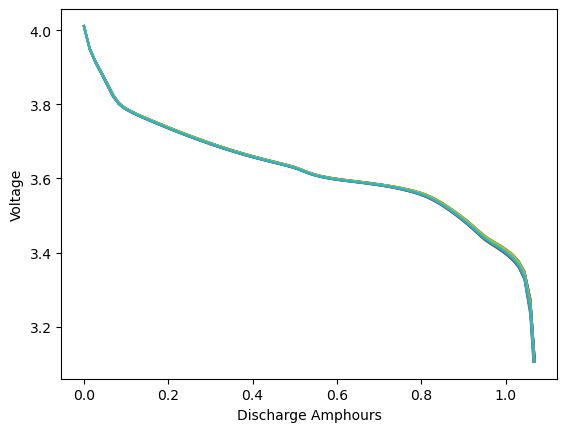

In [2]:
reduction = [0.2, 0.4, 0.6, 0.8, 1.0]
subregion_id = 1
subregion = 1
for reduc in reduction:
    properties_and_echem_from_volume(reduc, subregion_id, subregion)

At t = 542.425 and h = 2.63602e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.516 and h = 1.98534e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.061 and h = 1.46552e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.258 and h = 7.49454e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 247.349 and h = 5.91546e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.894 and h = 2.88751e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 533.741 and h = 3.21405e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 242.832 and h = 2.67706e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.3771 and h = 3.08608e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 545.039 and h = 1.17483e-15, the corrector convergence failed repeatedly or with |h| = hmin.


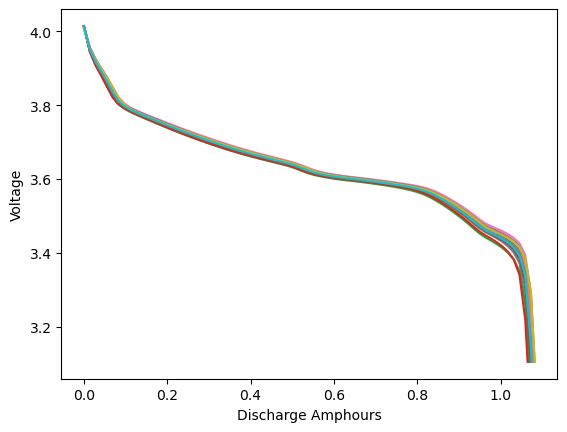

At t = 565.888 and h = 9.40862e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 274.979 and h = 3.56684e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.524 and h = 2.56409e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 563.904 and h = 6.32373e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 272.995 and h = 3.93117e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 127.54 and h = 1.25632e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 575.259 and h = 6.97845e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 284.35 and h = 1.05683e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.895 and h = 3.21407e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 578.721 and h = 9.24495e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

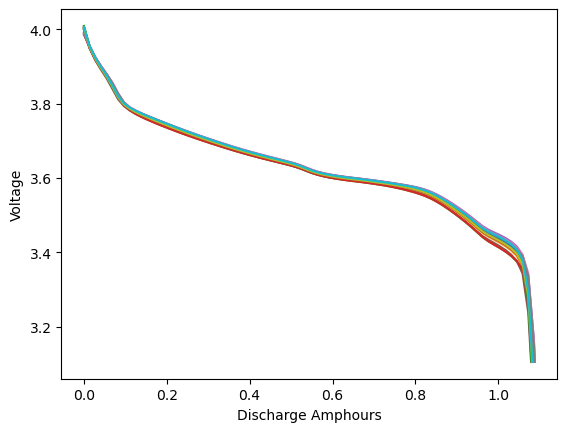

At t = 547.396 and h = 5.18263e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 256.487 and h = 6.22033e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.032 and h = 5.20041e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 549.923 and h = 1.05968e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.014 and h = 9.94039e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.56 and h = 1.0413e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 564.503 and h = 8.82833e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 273.594 and h = 1.54733e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 128.14 and h = 9.36712e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 572.03 and h = 2.98712e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t

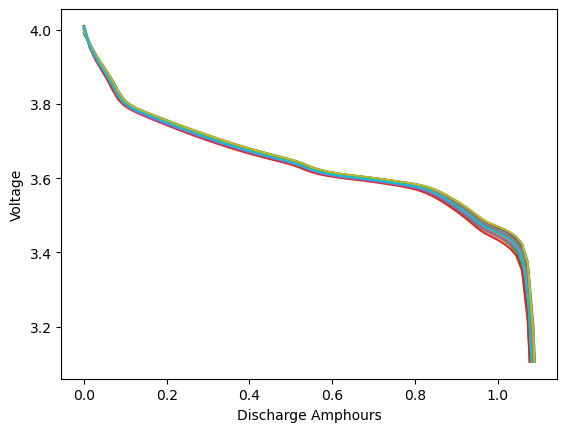

At t = 565.688 and h = 8.82462e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 274.779 and h = 1.78722e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.325 and h = 9.37106e-22, the corrector convergence failed repeatedly or with |h| = hmin.


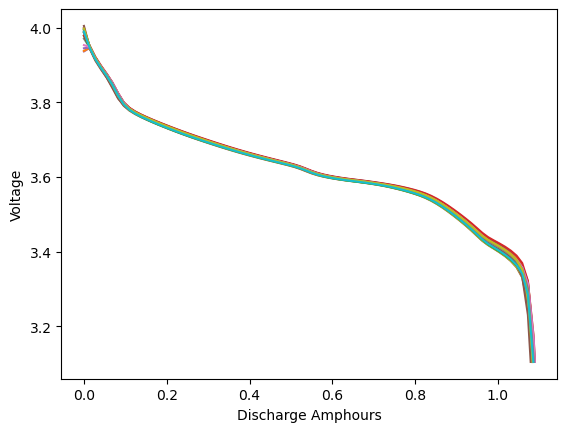

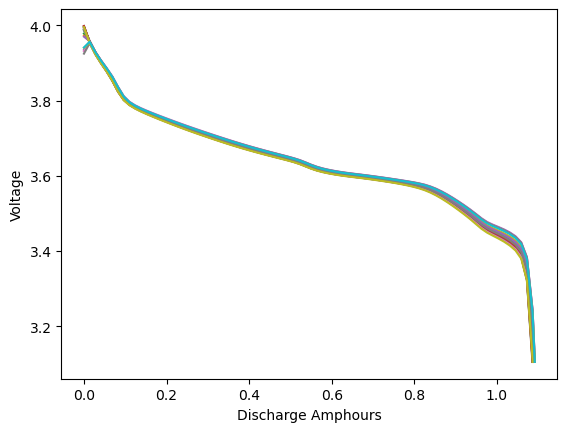

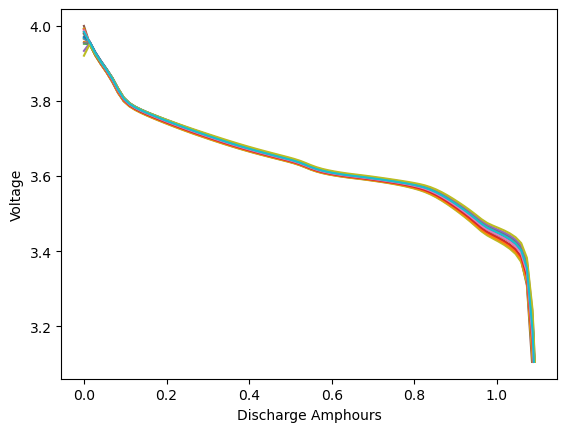

At t = 562.118 and h = 1.79411e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.209 and h = 6.73672e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 125.755 and h = 3.33934e-14, the corrector convergence failed repeatedly or with |h| = hmin.


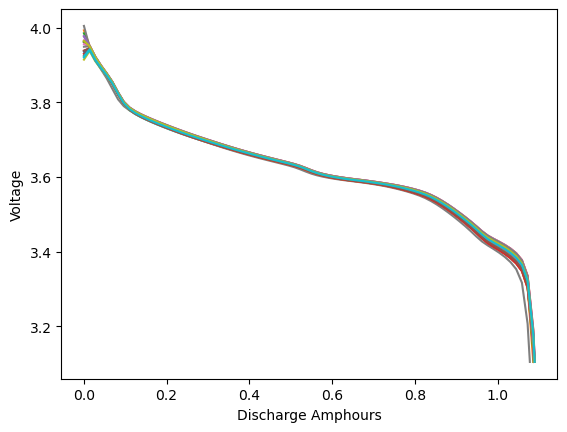

At t = 542.078 and h = 5.71225e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.169 and h = 3.143e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.714 and h = 5.29806e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 556.626 and h = 8.59926e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 265.717 and h = 4.10171e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.262 and h = 1.58263e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 534.186 and h = 2.8642e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.277 and h = 2.49609e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.8227 and h = 2.73082e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 528.218 and h = 3.767e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

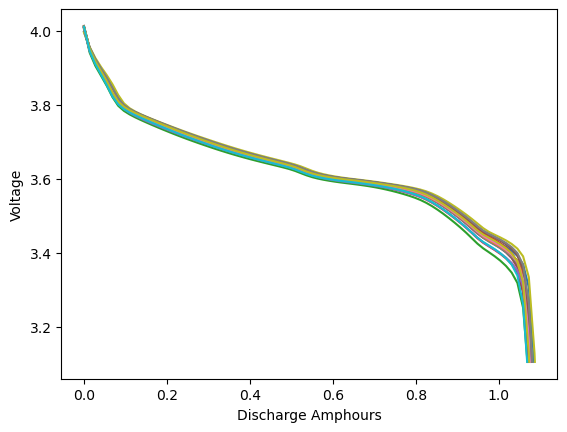

At t = 579.296 and h = 3.66579e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 288.387 and h = 2.82893e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 142.933 and h = 9.57656e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 568.331 and h = 3.73844e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 277.422 and h = 3.04669e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 131.967 and h = 5.87357e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 546.2 and h = 5.51541e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.291 and h = 5.16734e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.837 and h = 9.29913e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 560.325 and h = 7.88865e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At

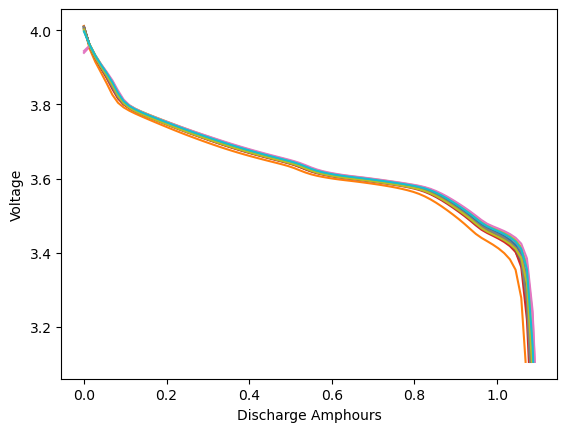

At t = 552.496 and h = 1.00232e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 261.587 and h = 1.88454e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.132 and h = 6.10901e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 542.96 and h = 3.03785e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 252.051 and h = 1.44704e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.596 and h = 1.19531e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.268, , mxstep steps taken before reaching tout.
At t = 229.359, repeated recoverable residual errors.
At t = 522.339 and h = 9.59205e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.43 and h = 4.86227e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 85.9755 and h = 3.47833e-17, the corrector convergence failed repeatedly or with |

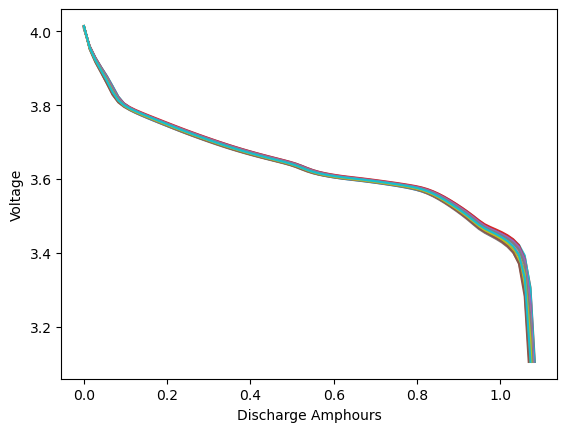

At t = 552.94 and h = 6.19127e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 262.03 and h = 3.35573e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.576 and h = 3.14686e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 567.053 and h = 1.8889e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 276.144 and h = 6.9356e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 130.689 and h = 8.68448e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 562.328 and h = 2.63526e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 271.419 and h = 5.90179e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 125.964 and h = 8.85221e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 553.95 and h = 2.28393e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

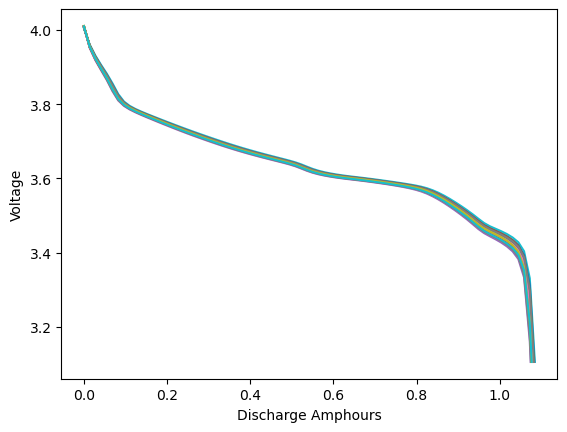

At t = 498.409 and h = 8.18564e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.5 and h = 6.07114e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.855 and h = 1.26307e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.946 and h = 3.39774e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.491 and h = 1.78407e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 530.464 and h = 8.16504e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 239.555 and h = 1.41246e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 94.1002 and h = 1.16402e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 509.699 and h = 1.69666e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.79 and h = 5.56442e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At 

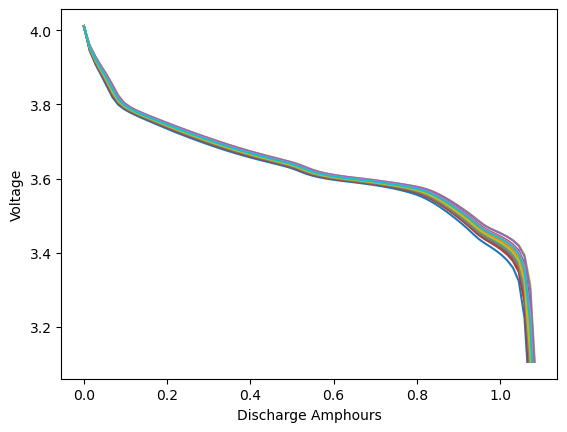

At t = 525.732 and h = 3.12443e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.823 and h = 4.99464e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 546.645 and h = 1.93669e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.735 and h = 1.77256e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.281 and h = 2.25962e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 541.177 and h = 8.26532e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 250.268 and h = 2.53054e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 104.814 and h = 1.9284e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 545.673 and h = 1.64934e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.764 and h = 6.85023e-14, the corrector convergence failed repeatedly or with |h| = hmin.
A

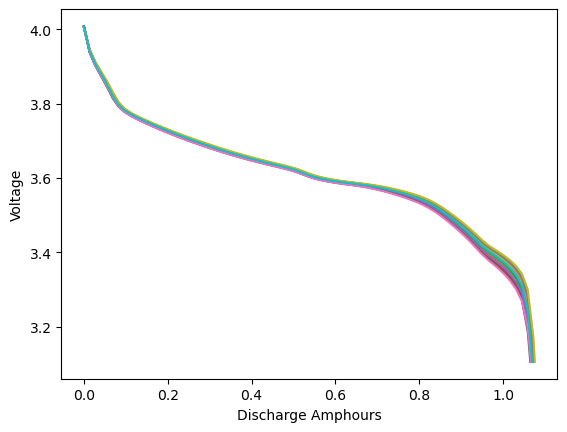

At t = 507.542 and h = 1.85053e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.633 and h = 3.59057e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 526.697 and h = 3.39047e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.788 and h = 1.20505e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.3331 and h = 1.24188e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 514.346 and h = 2.618e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.437 and h = 1.33695e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 527.864 and h = 1.05242e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.955 and h = 5.52685e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.5 and h = 1.99128e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

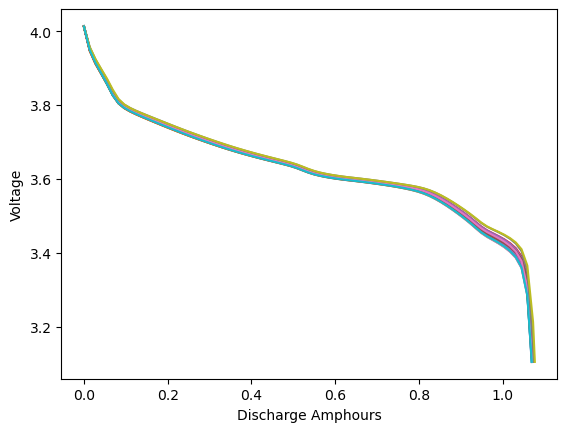

At t = 566.843 and h = 8.62413e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 275.934 and h = 1.28042e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 130.479 and h = 2.28792e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 564.466 and h = 3.5773e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 273.556 and h = 2.36609e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 128.102 and h = 2.50317e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 524.751 and h = 7.40892e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 233.841 and h = 8.56461e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 579.409 and h = 2.65709e-28, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 288.5 and h = 1.53042e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At 

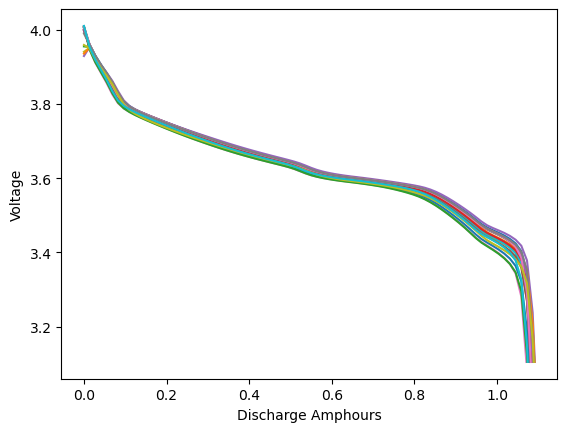

At t = 521.086 and h = 5.98306e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 230.177 and h = 8.50353e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 555.335 and h = 1.76572e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.426 and h = 2.54931e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 118.972 and h = 1.45639e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 557.354 and h = 1.89307e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 266.445 and h = 2.10386e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.99 and h = 1.65479e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 542.917 and h = 1.99134e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 252.008 and h = 2.52812e-16, the corrector convergence failed repeatedly or with |h| = hmin.
A

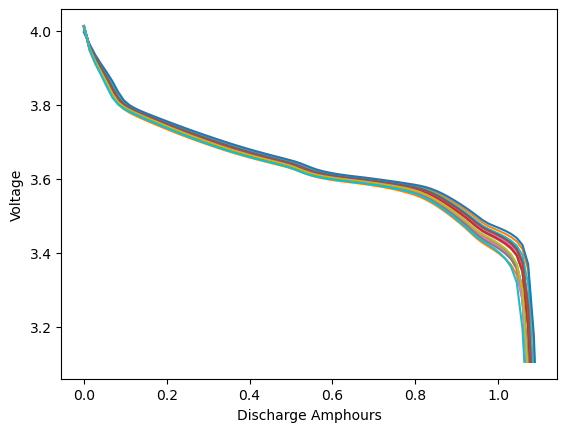

At t = 544.423 and h = 1.87095e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.514 and h = 1.46546e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.059 and h = 1.15441e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 548.857 and h = 2.35548e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 257.948 and h = 1.48331e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.494 and h = 3.79429e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 547.089 and h = 1.57654e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 256.18 and h = 1.52105e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.726 and h = 8.51369e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 569.453 and h = 2.77072e-14, the corrector convergence failed repeatedly or with |h| = hmin.
A

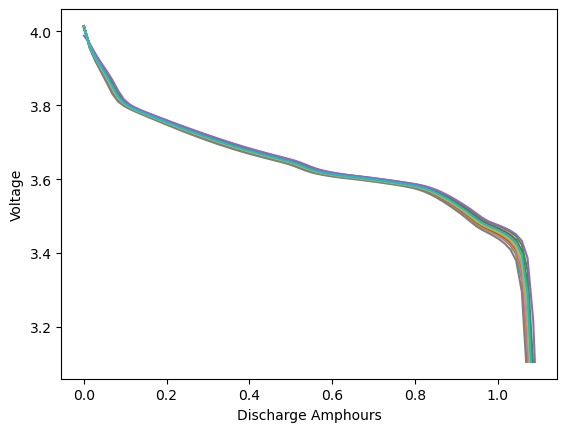

At t = 546.414 and h = 6.87704e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.505 and h = 4.45977e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.05 and h = 1.60531e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 525.813 and h = 9.32129e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.904 and h = 4.17897e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.4497 and h = 4.557e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 575.013 and h = 9.83227e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 284.104 and h = 8.62393e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.65 and h = 6.31238e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 564.672 and h = 1.3729e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

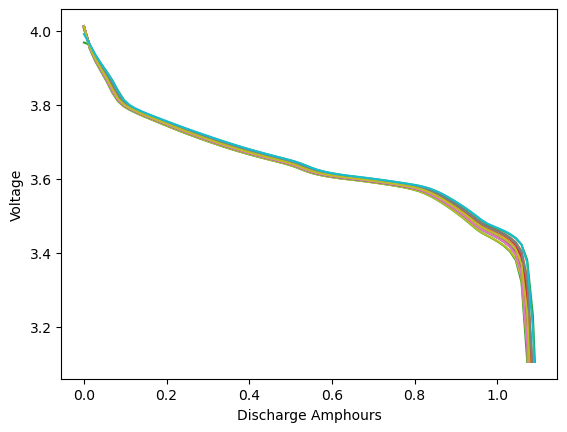

At t = 571.86 and h = 2.44683e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 280.951 and h = 9.10726e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 135.497 and h = 1.4479e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 563.511 and h = 1.82351e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 272.602 and h = 4.35925e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 127.147 and h = 3.83756e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 579.271 and h = 4.65458e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 288.362 and h = 3.87744e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 142.907 and h = 8.57709e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 580.463 and h = 1.19293e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At

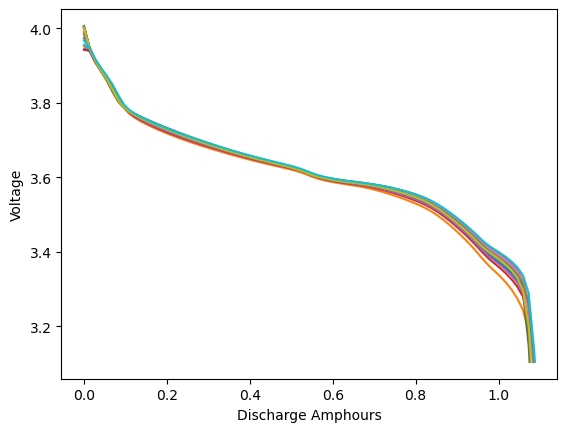

At t = 537.612 and h = 2.72895e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 246.703 and h = 4.76144e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.248 and h = 8.40022e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 554.303 and h = 2.41203e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.394, repeated recoverable residual errors.
At t = 117.939 and h = 3.30408e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 564.877 and h = 8.85405e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 273.968 and h = 2.3315e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 128.513 and h = 9.14246e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 571.454 and h = 3.94618e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 280.545 and h = 1.50084e-14, the correct

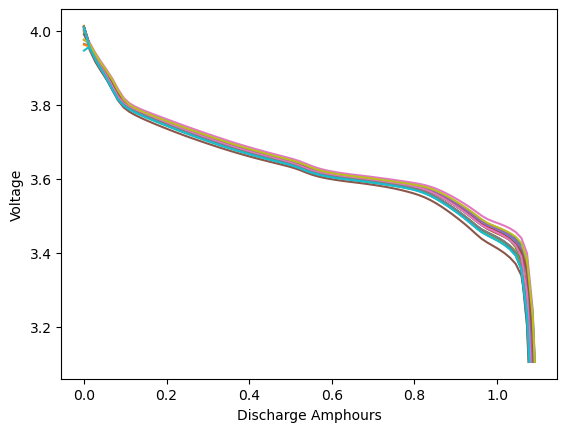

At t = 550.28 and h = 7.54628e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.371 and h = 4.03148e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.917 and h = 2.6599e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 579.134 and h = 3.16744e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 288.225 and h = 5.8621e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 142.77 and h = 4.26292e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 548.776 and h = 1.20902e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 257.867 and h = 2.73323e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.412 and h = 5.71309e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 577.769 and h = 8.97213e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t

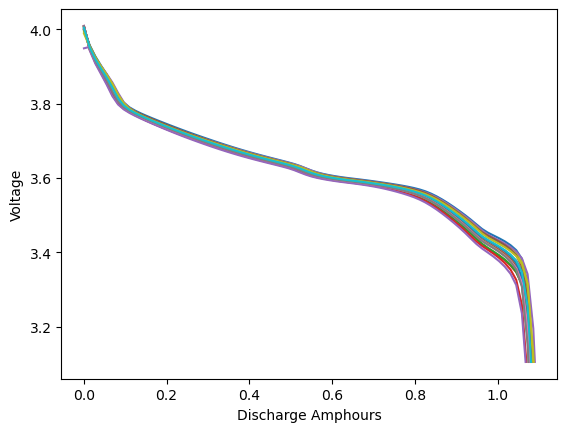

At t = 532.491 and h = 2.93145e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 241.582 and h = 1.72954e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.1273 and h = 1.42667e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 514.273 and h = 3.81486e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.364 and h = 6.45536e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.039 and h = 6.7733e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.13 and h = 1.49341e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 486.271 and h = 4.82433e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 195.362 and h = 8.79585e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.025 and h = 6.86791e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At

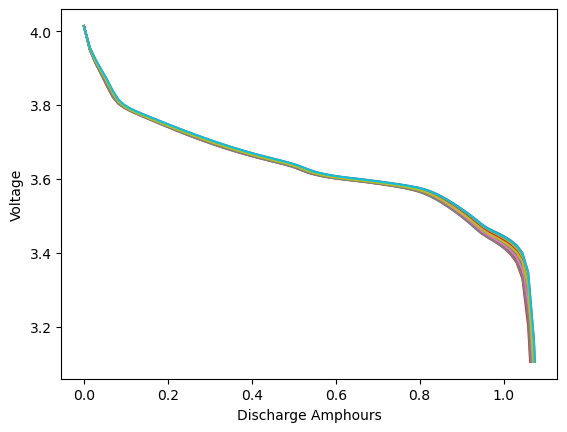

At t = 511.02 and h = 1.82766e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.111 and h = 2.33999e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.139 and h = 2.93838e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 229.23 and h = 5.57929e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 509.925 and h = 2.32165e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 219.016 and h = 5.32912e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.596 and h = 2.3358e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 225.687 and h = 2.15148e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 529.616 and h = 6.28039e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.707 and h = 4.37384e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At 

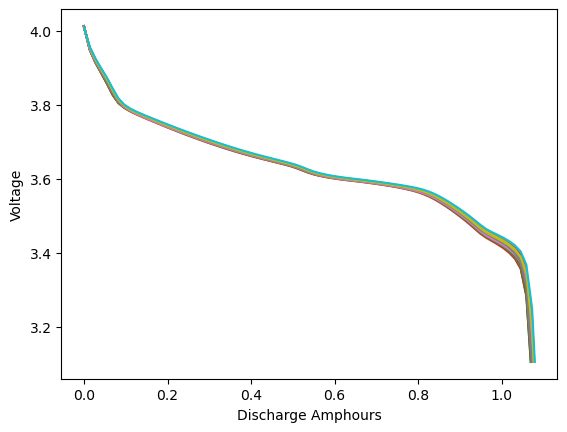

At t = 509.503 and h = 1.07332e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 218.594 and h = 2.05342e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 483.09, repeated recoverable residual errors.
At t = 192.18 and h = 2.36255e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 525.149 and h = 4.68563e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 234.24 and h = 6.60222e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.7858 and h = 1.00781e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.736 and h = 8.89926e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.827 and h = 4.03419e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.994 and h = 7.37567e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 201.085 and h = 2.10423e-13, the corrector

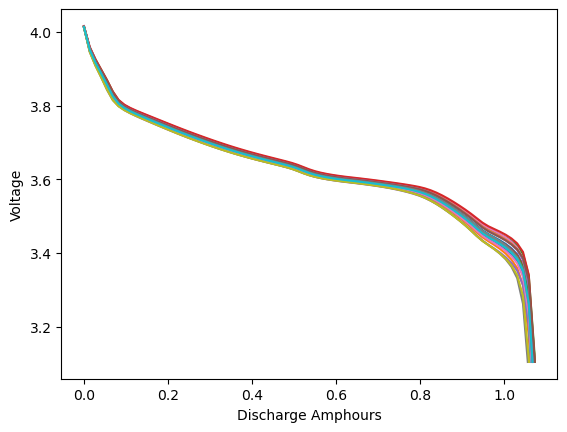

At t = 512.004 and h = 5.83077e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 221.095 and h = 8.47719e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 546.309 and h = 2.90715e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.399 and h = 2.40984e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.945 and h = 5.31592e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 533.073, repeated recoverable residual errors.
At t = 242.164 and h = 2.30227e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.7096 and h = 6.48921e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 518.401 and h = 1.64734e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 227.492 and h = 6.76817e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 560.905 and h = 2.76148e-14, the correc

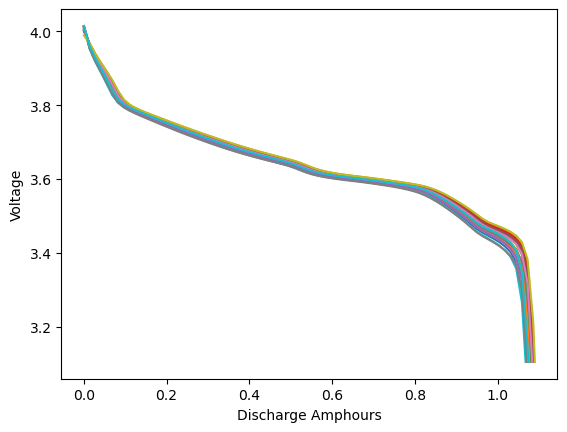

At t = 546.031 and h = 2.59536e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.122 and h = 2.66054e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.668 and h = 4.07158e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 548.666 and h = 1.59954e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 257.757 and h = 3.70602e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.302 and h = 3.29389e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 557.188 and h = 3.76655e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 266.279 and h = 1.94299e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.825 and h = 1.28125e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 549.159 and h = 4.84488e-16, the corrector convergence failed repeatedly or with |h| = hmin.


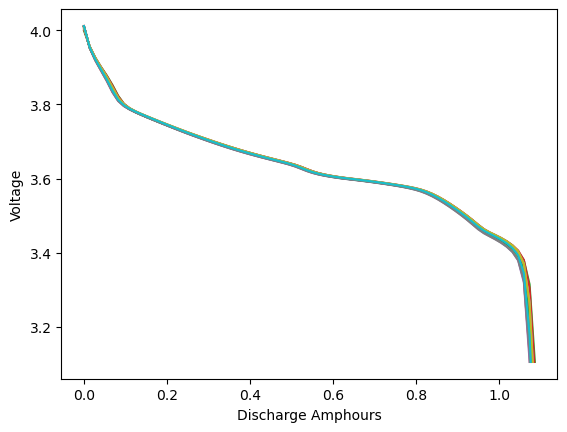

At t = 493.963 and h = 1.70387e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 203.054 and h = 5.36164e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 492.625 and h = 1.96131e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 201.716 and h = 4.30794e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.559 and h = 2.96616e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 193.65 and h = 1.40192e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.977 and h = 1.35846e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 205.068 and h = 4.43669e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 489.709 and h = 3.1847e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.8 and h = 6.25925e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t

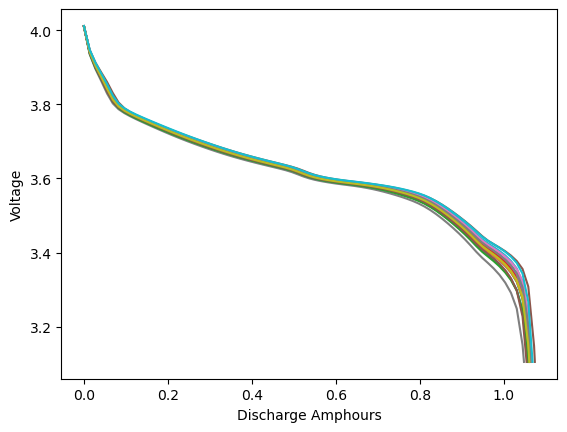

At t = 537.235 and h = 1.46364e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 246.326 and h = 1.33797e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.871 and h = 5.78808e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 510.548 and h = 2.51464e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 219.639 and h = 2.65088e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 518.783, repeated recoverable residual errors.
At t = 227.874 and h = 4.08843e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 529.551 and h = 3.06799e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 238.642 and h = 1.29155e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.1876 and h = 2.5755e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 521.879 and h = 2.44897e-22, the correct

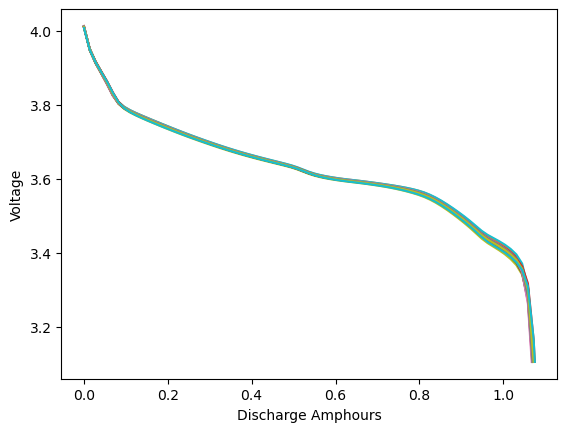

In [3]:
reduction = 0.2
subregion_id = [1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,6,6,7]
subregion =    [1,2,3,4,5,6,7,2,3,4,5,6,7,3,4,5,6,7,4,5,6,7,5,6,7,6,7,7]
for sub_id, sub in zip(subregion_id, subregion):
    properties_and_echem_from_volume(reduction, sub_id, sub)